### Hypothesis Testing
#### Classical Hypothesis Testing
So far, when exploring datasets and finding several "apparent effects", like finding differences between first babies and others, we have taken these effects at face value. Now, it's time to put these effects to the test. Are these effects likely to appear in the larger population?

The goal of **classical hypothesis testing** is to answer this question:
> Given a sample and an apparent effect, what is the probability of seeing such an effect by chance?

These are the steps to answer this question:
1. Quantify the size of the apparent effect by choosing a **test statistic**. In the NSFG example, the apparent effect is a difference in pregnancy lengths between first babies and others. The test statistic we can choose for this is the difference in means between the two groups; that is, `mean_first - mean_others`. As shown below, the test statistic came up positive, which means that the data shows that, on average, live firstborns have longer pregnancy lengths than others, and thus are born later than others. But since we know that means are skewed by outliers, we can also show the median difference between the two groups. The median difference ended up at exactly 0.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_pickle("nsfg_data.pkl")
live = df[df["outcome"] == 1]
firsts = live[live["birthord"] == 1]["prglngth"]
others = live[live["birthord"] != 1]["prglngth"]
diffMean = firsts.mean() - others.mean()
diffMedian = firsts.median() - others.median()
print("Test statistic\n", "\tDifference of mean pregnancy lengths between firsts and others:", diffMean)
print("\tDifference of median pregnancy lengths between firsts and others:", diffMedian)

Test statistic
 	Difference of mean pregnancy lengths between firsts and others: 0.07803726677754952
	Difference of median pregnancy lengths between firsts and others: 0.0


2. Define a **null hypothesis**, which is a model of the system based on the assumption that the apparent effect is **NOT** real. In the NSFG example, the null hypothesis is that there is no difference between the pregnancy lengths of the first babies and others; that is, the pregnancy lengths for both groups have the same distribution.
3. Compute a **p-value**, which is the probability of seeing the apparent effect if the null hypothesis is **true**. For the NSFG example, as done in code:

In [2]:
def MeanPValue(group1, group2, iterations=1000):
    # MakeModel
    group1Count = len(group1)
    group2Count = len(group2)

    # Create a pool of pregnancy length values by combining the values of the firsts and others in one array
    pool = np.hstack((group1, group2))

    # RunModel
    testStatistics = []
    for i in range(iterations):
        # Destructively shuffle the pool
        np.random.shuffle(pool)
        group1TestData = pool[:group1Count] # should be of size firstsCount
        group2TestData = pool[group1Count:] # since this is the leftover, it will be of size othersCount

        # TestModel
        testStatistic = abs(group1TestData.mean() - group2TestData.mean())
        testStatistics.append(testStatistic)

    # Find p-value
    actualTestStatistic = abs(group1.mean() - group2.mean()) # Based on the actual values of firsts and others
    count = sum(1 for x in testStatistics if x >= actualTestStatistic)
    pValue = count / iterations
    return (pValue, testStatistics, actualTestStatistic)

pValue, testStatistics, actualTestStatistic = MeanPValue(firsts, others)
print("P-Value:", pValue, "or", pValue * 100, "%", "\nDifference in pregnancy lengths:", actualTestStatistic)

P-Value: 0.158 or 15.8 % 
Difference in pregnancy lengths: 0.07803726677754952


4. Finally, we interpret the result. If the p-value is low, the effect is said to be **statistically significant**, which means that it is unlikely to have occurred by chance. We can then infer that the effect is more likely to appear in the larger population. Based on the p-value above, we get a value of `0.17` or `17%`. This means that we expect to see a difference as big as the observed effect about 17% of the time, therefore this effect is **NOT** statistically significant. If we were to graph the differences of the means of pregnancy lengths in a CDF graph and mark where the actual mean difference is, it would look like this:

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from cycler import cycler

matplotlib.style.use("dark_background")
%matplotlib inline
rcParams["figure.figsize"] = (15, 6)
rcParams["axes.prop_cycle"] = cycler(color=["#4299E1", "#F56565", "#48BB78"])
rcParams["axes.facecolor"] = "#1A202C"
rcParams["axes.edgecolor"] = "#A0AEC0"
rcParams["axes.grid"] = True
rcParams["grid.color"] = "#A0AEC0"
rcParams["grid.alpha"] = 0.7
rcParams["axes.titlecolor"] = "#A0AEC0"
rcParams["axes.labelcolor"] = "#A0AEC0"
rcParams["xtick.color"] = "#A0AEC0"
rcParams["ytick.color"] = "#A0AEC0"

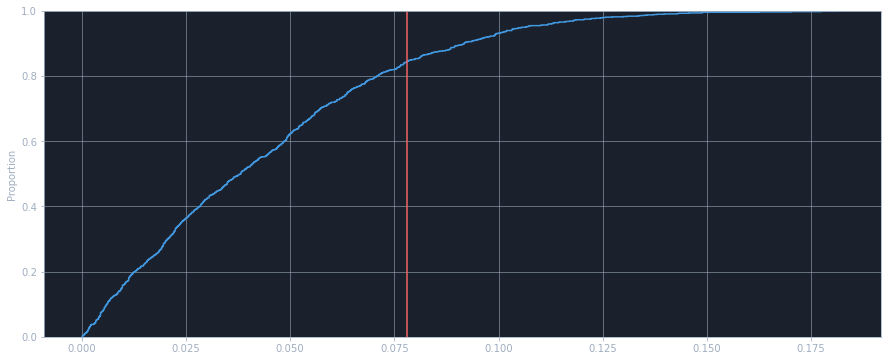

In [4]:
import seaborn as sns

sns.ecdfplot(x=testStatistics)
plt.plot([actualTestStatistic, actualTestStatistic], [0, 1])
plt.draw()

Let's try doing the same thing for birth weights:

In [5]:
firstWeights = live[live["birthord"] == 1]["totalwgt_lb"]
otherWeights = live[live["birthord"] != 1]["totalwgt_lb"]

pValue, testStatistics, actualTestStatistic = MeanPValue(firstWeights, otherWeights)
print("P-Value:", pValue, "or", pValue * 100, "%", "\nDifference in weights:", actualTestStatistic)

P-Value: 0.0 or 0.0 % 
Difference in weights: 0.12476118453549034


Unlike that of pregnancy lengths, the simulation for birth weights never yields an effect as big as the observed difference, `0.12 lbs`. This means the difference in birth weight **IS** statistically significant.

#### Other Test Statistics
Choosing the best test statistic depends on what question or hypothesis you're trying to address. For example, if the hypothesis to test is that pregnancy lengths for first babies are different from that of other babies, then it makes sense to test the absolute difference in means. This kind of test is called **two-sided**, because it counts both sides of the distribution of differences.

However, if our hypothesis to test instead is that first babies are born late, then we should be using a **one-sided** test, where only one side of the distribution of differences is counted. Here is how it looks likes:

In [6]:
def MeanPValueOneSided(group1, group2):
    group1Count = len(group1)
    group2Count = len(group2)

    pool = np.hstack((group1, group2))

    testStatistics = []
    iterations = 1000
    for i in range(iterations):
        np.random.shuffle(pool)
        group1TestData = pool[:group1Count]
        group2TestData = pool[group1Count:]

        testStatistic = group1TestData.mean() - group2TestData.mean() # This is the only thing we changed from the previous function
        testStatistics.append(testStatistic)

    actualTestStatistic = group1.mean() - group2.mean()
    count = sum(1 for x in testStatistics if x >= actualTestStatistic)
    pValue = count / iterations
    return (pValue, testStatistics, actualTestStatistic)

pValue, testStatistics, actualTestStatistic = MeanPValueOneSided(firsts, others)
print("P-Value (One-Sided):", pValue, "or", pValue * 100, "%", "\nDifference (one-sided) in pregnancy lengths:", actualTestStatistic)

P-Value (One-Sided): 0.096 or 9.6 % 
Difference (one-sided) in pregnancy lengths: 0.07803726677754952


In general, the p-value for a one-sided test is about half the p-value for a two-sided test.

The one-sided hypothesis, that first babies are born late, is more specific than the two-sided hypothesis, so the p-value is smaller. However, the difference is still not statistically significant.

> Note: It is widely agreed upon that a p-value less than `0.05 or 5%` is considered statistically significant.

We can use the same classic hypothesis testing framework to test for a difference in standard deviation. In earlier chapters, we saw some evidence that first babies are more likely to be either early or late, but less likely to be on time. Therefore, we may hypothesize that its standard deviation is **higher (one-sided)** instead of **different (two-sided)**. Let's test for it:

In [7]:
def StdPValueOneSided(group1, group2):
    group1Count = len(group1)
    group2Count = len(group2)

    pool = np.hstack((group1, group2))

    testStatistics = []
    iterations = 1000
    for i in range(iterations):
        np.random.shuffle(pool)
        group1TestData = pool[:group1Count]
        group2TestData = pool[group1Count:]

        testStatistic = group1TestData.std() - group2TestData.std()
        testStatistics.append(testStatistic)

    actualTestStatistic = group1.std() - group2.std()
    count = sum(1 for x in testStatistics if x >= actualTestStatistic)
    pValue = count / iterations
    return (pValue, testStatistics, actualTestStatistic)

pValue, testStatistics, actualTestStatistic = StdPValueOneSided(firsts, others)
print("P-Value:", pValue, "or", pValue * 100, "%", "\nStandard difference (one-sided) in pregnancy lengths:", actualTestStatistic)

P-Value: 0.069 or 6.9 % 
Standard difference (one-sided) in pregnancy lengths: 0.1760490642294399


As we can see, the p-value is around 0.08, which means this test statistic is not significant.

#### Testing a Correlation
The classic hypothesis testing framework can also test for correlations between variables. Using the NSFG data set, let's see if there's a correlation between the birth weight and the mother's age.
> Note: It is first recommended to look at the two variables' scatter plot to see if there's a possible correlation and not waste time if there isn't.

In [8]:
noNan = live[live["totalwgt_lb"].isna() == False]
birthWgt = noNan["totalwgt_lb"]
momAge = noNan["agepreg"]

def Covariance(xSample, ySample):
    xMean = xSample.mean()
    yMean = ySample.mean()
    return np.dot(xSample - xMean, ySample - yMean) / xSample.count()

def Pearson_Covariance(xSample, ySample):
    covariance = Covariance(xSample, ySample)
    stds = xSample.std() * ySample.std()
    return covariance / stds

def Spearman_Coefficient(xSample, ySample):
    return Pearson_Covariance(xSample.rank(), ySample.rank())

print("Correlation (Spearman):", Spearman_Coefficient(momAge, birthWgt))
print("Correlation (Pearson):", Pearson_Covariance(momAge, birthWgt))

Correlation (Spearman): 0.09459957306813607
Correlation (Pearson): 0.06882635429188806


The correlation between the birth weight and the mother's age is about `0.09` using Spearman and `0.07` using Pearson. Since we don't expect either a positive or negative correlation, we will do a two-sided test using the absolute value of Pearson correlation. The null hypothesis is that there is no correlation between the mother's age and the birth weight. By shuffling the observed value, we can simulate a world where the distributions of age and birth weight are the same, but the variables are unrelated.

In [9]:
def CorrelationPValue(var1, var2):
    testStatistics = []
    iterations = 1000
    for i in range(iterations):
        testStatistic = abs(Pearson_Covariance(var1.sample(frac=1), var2))
        testStatistics.append(testStatistic)

    actualTestStatistic = abs(Pearson_Covariance(var1, var2))
    count = sum(1 for x in testStatistics if x >= actualTestStatistic)
    pValue = count / iterations
    return (pValue, testStatistics, actualTestStatistic)

pValue, testStatistics, actualTestStatistic = CorrelationPValue(momAge, birthWgt)
print("P-Value:", pValue, "or", pValue * 100, "%", "\nCorrelation between mom age and birth weight:", actualTestStatistic)

P-Value: 0.0 or 0.0 % 
Correlation between mom age and birth weight: 0.06882635429188806


According to this, the correlation of `0.07` between the mother's age and birth weight is statistically significant.
> Note: **Statistically significant** does not always mean that an effect is important or significant in practice. It only means that this statistic is **unlikely** to have occured **by chance.**

#### Testing Proportions
Say that someone is using a loaded die so that some numbers are more likely to come up than others. You want to prove that it's a loaded die and you get these frequencies when you rolled it 60 times:
```
1 - 8
2 - 9
3 - 19
4 - 5
5 - 8
6 - 11
```
It seems that 3 comes up more than expected, and 4 comes up less than expected. But are these differences statistically significant?

Let's set up our classical hypothesis testing:
1. Our **test statistic** is the total absolute difference between the expected and observed frequencies. For our actual test statistic, the expected value for each die number is 10 out of 60 rolls, therefore the deviations are |-2|, |-1|, |9|, |-5|, |-2|, and |1|. Adding up all these values would yield us a total absolute difference (or total deviation) of 20.
2. Our **null hypothesis** is that the die is fair. We can simulate this by rolling a fair dice 60 times, for 1000 times.
3. We calculate the **p-value** by getting all the total absolute differences of all the simulated rolls we did and counting how many of them is larger than the actual test statistic established above.
4. We then **evaluate the p-value**; if the p-value is less than 0.05, then we can say that the effect is statistically significant and is therefore likely to not have come up by chance.

In [10]:
def LoadedDie(observedFreqs):
    testStatistics = []
    iterations = 1000
    numRolls = 60
    dieValues = [1, 2, 3, 4, 5, 6]
    expected = np.ones(6) * numRolls / 6
    
    for i in range(iterations):
        rolls = np.random.choice(dieValues, numRolls, replace=True)
        observed = pd.Series(rolls).value_counts().values # Get the frequencies of each die number
        testStatistic = sum(abs(observed - expected))
        testStatistics.append(testStatistic)

    actualTestStatistic = sum(abs(observedFreqs - expected))
    count = sum(1 for x in testStatistics if x >= actualTestStatistic)
    pValue = count / iterations
    return (pValue, testStatistics, actualTestStatistic)

observedFreqs = [8, 9, 19, 5, 8, 11]
pValue, testStatistics, actualTestStatistic = LoadedDie(observedFreqs)
print("P-Value:", pValue, "or", pValue * 100, "%", "\nTotal Deviation of Loaded Die:", actualTestStatistic)

P-Value: 0.116 or 11.600000000000001 % 
Total Deviation of Loaded Die: 20.0


The p-value that we get is 0.13, which means that the apparent effect is not statistically significant and that it is likely that the real observed frequencies has come up by chance.

#### Chi-squared tests
Previously, we have used the total deviation as the test statistic. But for testing proportions, it is more common to use the **chi-squared statistic**. The difference is that instead of taking the absolute values of the difference of the observed and expected (`sum(abs(observed-expected))`), we instead square the difference and divide by the expected values, then sum it all up (`sum((observed - expected)**2 / expected)`). This will give more weight to large deviations, and dividing by expected standardizes the deviations.

Let's see what p-value we get using this method:

In [11]:
def LoadedDieChiSqr(observedFreqs):
    testStatistics = []
    iterations = 1000
    numRolls = 60
    dieValues = [1, 2, 3, 4, 5, 6]
    expected = np.ones(6) * numRolls / 6
    
    for i in range(iterations):
        rolls = np.random.choice(dieValues, numRolls, replace=True)
        observed = pd.Series(rolls).value_counts().values
        testStatistic = sum((observed - expected)**2 / expected) # This line changed from the previous method
        testStatistics.append(testStatistic)

    actualTestStatistic = sum((observedFreqs - expected)**2 / expected) # This line also changed
    count = sum(1 for x in testStatistics if x >= actualTestStatistic)
    pValue = count / iterations
    return (pValue, testStatistics, actualTestStatistic)

observedFreqs = [8, 9, 19, 5, 8, 11]
pValue, testStatistics, actualTestStatistic = LoadedDieChiSqr(observedFreqs)
print("P-Value:", pValue, "or", pValue * 100, "%", "\nStandard Deviation of Loaded Die:", actualTestStatistic)

P-Value: 0.039 or 3.9 % 
Standard Deviation of Loaded Die: 11.6


The p-value we get using the chi-squared statistic is about `0.04`, much smaller than using the total deviation. Based on our 0.05 threshold, this effect is statistically significant. However, considering the two tests together, we can say that the results are borderline. We can't rule out the possibility that the die is loaded, but we also can't convict the person as cheating using this die.

> Note: The p-value depends on the choice of test statistic and the model of the null hypothesis, and sometimes these choices determine whether an effect is statistically significant or not.

#### Testing First Babies
In an earlier chapter, we saw several apparent differences in the distribution of pregnancy length, between 35 to 43 weeks, depending on whether the baby is the first born by that mother or not. To see whether those differences are statistically significant, we can use a test based on a chi-squared statistic.

In [12]:
def ChiSquared(observed, expected):
    return sum((observed - expected)**2 / expected)

def ProbHist(values, bins):
    hist, bins = np.histogram(values, bins=bins, density=True)
    return hist

def DistHist(values, bins):
    hist, bins = np.histogram(values, bins=bins, density=False)
    return hist

def PregLenDiffChiSqr(group1, group2, length):
    # Make Model
    group1Count = len(group1)
    group2Count = len(group2)

    pool = np.hstack((group1, group2))
    # We use a PMF here so we can just multiply this by the observed count to get the expected values
    expectedProbs = ProbHist(pool, length) 
    
    testStatistics = []
    iterations = 1000
    for i in range(iterations):
        # Run Model
        np.random.shuffle(pool)
        group1TestData = pool[:group1Count]
        group2TestData = pool[group1Count:]

        # Test Model
        testStatistic = ChiSquared(DistHist(group1TestData, length), expectedProbs * len(group1TestData)) + ChiSquared(DistHist(group2TestData, length), expectedProbs * len(group2TestData))
        testStatistics.append(testStatistic)

    actualTestStatistic = ChiSquared(DistHist(group1, length), expectedProbs * group1Count) + ChiSquared(DistHist(group2, length), expectedProbs * group2Count)
    count = sum(1 for x in testStatistics if x >= actualTestStatistic)
    pValue = count / iterations
    return (pValue, testStatistics, actualTestStatistic)

zoomedData = live.loc[(live["prglngth"] >= 35) & (live["prglngth"] <= 43)]
firsts = zoomedData[zoomedData["birthord"] == 1]["prglngth"]
others = zoomedData[zoomedData["birthord"] != 1]["prglngth"]

pValue, testStatistics, actualTestStatistic = PregLenDiffChiSqr(firsts, others, 43 - 35 + 1)
print("P-Value:", pValue, "or", pValue * 100, "%", "\nSum Chi Squared:", actualTestStatistic)

P-Value: 0.0 or 0.0 % 
Sum Chi Squared: 209.07216653183275


Based on this result, this apparent effect - that there is a difference in distributions of the pregnancy lengths between the first and others - is statistically significant. The null hypothesis - that there is no difference between the distributions - is therefore unlikely to be true.

#### Errors
In classical hypothesis testing, an effect is considered statistically significant if the p-value is below some threshold, which is commonly `0.05` or `5%`. However, consider these questions:
- If the effect is actually due to chance, what is the probability that we will wrongly consider it **significant**? This probability is the **false positive rate**.
- If the effect is real, what is the chance that the hypothesis test will fail (where we wrongly consider it **insignificant**)? This probability is the **false negative rate**.

The **false positive rate** is the same as the threshold we use, which is `0.05` or `5%`. When we get a CDF for the test statistic we choose and find out how often a value chosen from that CDF exceed the 95th percentile, we'll find that it is chosen 5% of the time.

The **false negative rate** is harder to compute because it depends on the actual effect size, which we normally don't know about. One option we have is to compute a rate based on a hypothetical effect size. Basically, we will need to run our classical hypothesis testing for one test statistic multiple times, count how many p-values exceed our threshold of `0.05`, and divide that count by the number of runs we did.

We will be using the `MeanPValue()` function we created earlier to compare the pregnancy lengths between firstborns and others.

In [28]:
def FalseNegRate(group1, group2, numRuns=100):
    count = 0
    for i in range(numRuns):
        sample1 = np.random.choice(group1, len(group1), replace=True)
        sample2 = np.random.choice(group2, len(group2), replace=True)
        
        pValue, testStatistics, actualTestStatistic = MeanPValue(sample1, sample2, 101)
        if (pValue > 0.05):
            count += 1
            
    return count / numRuns

firsts = live[live["birthord"] == 1]["prglngth"]
others = live[live["birthord"] != 1]["prglngth"]
falseNeg = FalseNegRate(firsts, others)
print("False Negative Rate:", falseNeg)

pValue, testStatistics, actualTestStatistic = MeanPValue(firsts, others)
print("Difference in Pregnancy Length:", actualTestStatistic)

False Negative Rate: 0.72
Difference in Pregnancy Length: 0.07803726677754952


In our case, the false negative rate is about `0.7` or `70%`. In other words, if the effect is real and statistically significant, that is, the actual difference in mean pregnancy length is `0.078` weeks, we expect an experiment with this sample size to yield a negative test (if this difference in means is not statistically significant) about **70%** of the time.

This result is often presented the other way around: if the effect is real and the actual difference is `0.078` weeks, we should expect a positive test only **30%** of the time. This "correct positive rate" is called the **power** of the test, sometimes called **sensitivity**.

> Note: As a rule of thumb, a power of **80%** is considered acceptable, so we would say that the above test was "underpowered".

> Note 2: This test does **NOT** imply that there is no difference between the groups. It instead suggest that if there is a difference, it is too small to detect with this sample size.

#### Replication
The hypothesis testing process demonstrated in this chapter is not good practice because of these reasons:
1. Performing multiple tests. One hypothesis test means that, if the false positive rate is 1 in 20, the false positive rate for only that test is 1 in 20. But if you run 20 different hypothesis tests, testing different test statistics, at least one of those tests may give a false positive.
2. Using the same dataset for exploration and testing. To compensate for multiple tests, it is best to either adjust the p-value threshold (see Holm-Bonferroni method) or partition the data into an exploration data and testing data, with the rows for both partition chosen randomly.